In [1]:
import collections
# Prepare paths to local utilities
import os
import sys
import pickle

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from processing.DataPreprocessor import DataPreprocessor
    from reservoir.HierarchyESNCuda import HierarchyESNCuda as HierarchyESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from hierarchyesn.HierarchyESNCuda import HierarchyESNCuda as HierarchyESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646,)
X_val shape: (339404, 6), Y_val shape: (339404,)
X_test shape: (562547, 6), Y_test shape: (562547,)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled shape

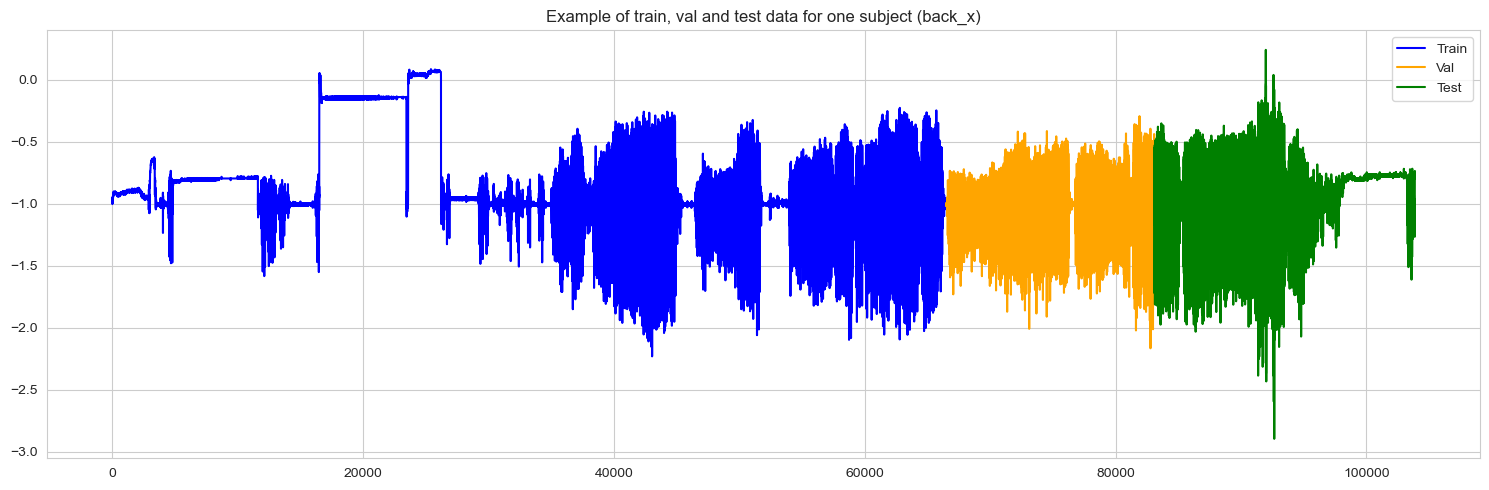

In [6]:
# Lets plot the data on a graph, colouring by whether it is train, val or test data
# Plot the column for back_x

train_set, val_set, test_set = data_preparation.get_sets()

plt.figure(figsize=(15, 5))

plt.plot(train_set[0]['back_x'], label='Train', color='blue')
plt.plot(val_set[0]['back_x'], label='Val', color='orange')
plt.plot(test_set[0]['back_x'], label='Test', color='green')
plt.legend()

plt.title(f'Example of train, val and test data for one subject (back_x)')
plt.tight_layout()
plt.show()

In [7]:
# Now we need to create the ESN

# We can star by defining the input weights for the data

# We will initially start by drawing on the best hyperparameters from the previous experiments
# To recap, the best hyperparameters were:
# Best Neurons: 500
# Best Density: 0.2
# Best Leakage Rate: 0.8
# Best Spectral Radius: 0.999
# Best Gamma: 0.999
# Best Method: uniform
# Best Sparsity: 0.8
# As we have two reservoirs, we will define the first reservoir the same as with the previous experiments
#  and the second reservoir will have smaller values in order to encourage the second reservoir to learn more from the first reservoir

# To do this, we will create a matrix of shape (n_neurons, n_features) where n_neurons is the number of neurons in the reservoir and n_features is the number of features in the input signal
# We will then populate this matrix from a density function where elements are 1 for a value p, and 0 for a value of 1-p
# This will give us a sparse matrix with a density of p

n_features = 6
density_1 = 0.2
density_2 = 0.5

weight_distribution_1 = 'uniform'
weight_distribution_2 = 'uniform'

# To keep things consistent, we will keep the total number of neurons the same as the previous experiments, so 500 total
# To begin with, we will split this evenly between the two reservoirs
n_neurons_1 = 250
n_neurons_2 = 250

# Generate the input weights
input_weights_1 = generate_input_weights(n_neurons_1, n_features, density_1, weight_distribution_1, seed=42)

# Check the shape of the input weights
print(f'Res1 Input weights shape: {input_weights_1.shape}')

input_weights_2 = generate_input_weights(n_neurons_2, n_features, density_2, weight_distribution_2, seed=42)

# Check the shape of the input weights
print(f'Res2 Input weights shape: {input_weights_2.shape}')


Res1 Input weights shape: (250, 6)
Res2 Input weights shape: (250, 6)


In [8]:
# Next, we initialise the ESN

class_weights = data_preparation.get_class_weights()

leakage_rate_1 = 0.8
spectral_radius_1 = 0.999
gamma_1 = 0.999
W_in_1 = input_weights_1

leakage_rate_2 = 0.5  # Lower leakage rate for the second reservoir
spectral_radius_2 = 0.8  # Lower spectral radius for the second reservoir
gamma_2 = 0.8  # Lower gamma for the second reservoir
W_in_2 = input_weights_2

esn = HierarchyESN(leakage_rate_1=leakage_rate_1, spectral_radius_1=spectral_radius_1, gamma_1=gamma_1, W_in_1=W_in_1,
                   n_neurons_1=n_neurons_1,
                   leakage_rate_2=leakage_rate_2, spectral_radius_2=spectral_radius_2, gamma_2=gamma_2, W_in_2=W_in_2,
                   n_neurons_2=n_neurons_2,
                   class_weights=class_weights, seed=42)

[]
Is CUDA available: True
HierarchyESN initialised with leakage_rate_1: 0.8, spectral_radius_1: 0.999, gamma_1: 0.999, n_neurons_1: 250, leakage_rate_2: 0.5, spectral_radius_2: 0.8, gamma_2: 0.8, n_neurons_2: 250


In [ ]:
# Now we need to train the ESN
# We will train the ESN using the training data

X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

# As a test, lets only take the first 1000 samples
n_samples = 500000
data_in = X_train_scaled
data_out = y_train_encoded

baseline_pickle = 'hierarchyESN_har70_baseline.pkl'

# If a pickle file exists for this baseline, we will load the ESN from the pickle file instead of training it
if not os.path.exists(baseline_pickle):
    esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)

    # Save the ESN to a pickle file
    with open(baseline_pickle, 'wb') as f:
        pickle.dump(esn, f)
else:
    # Load the ESN from the pickle file
    with open(baseline_pickle, 'rb') as f:
        esn = pickle.load(f)


  1%|          | 10000/1357646 [00:00<00:32, 41006.41it/s]

In [ ]:
# Now we can use the ESN to predict the output for the test data
y_pred = esn.forward(X_test_scaled)

# Check the shape of the predicted output
y_pred.shape


In [ ]:
# Get the first few rows of the predicted output
y_pred[:5]

In [ ]:
# The predicted output is a one-hot encoded array, so we need to decode it back to the original labels
y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

# Check the shape of the decoded output
y_pred_decoded.shape

In [ ]:
# Get the first few rows of the decoded output
y_pred_decoded[:5]

In [ ]:
# Now we can evaluate the accuracy of the ESN on the test data
# Start by plotting the true label and the predicted label on a graph

y_test_decoded = data_preparation.get_decoded_labels('test')

plt.figure(figsize=(15, 5))
plt.plot(y_test_decoded[:10000], label='True', color='blue')
plt.plot(y_pred_decoded[:10000], label='Predicted', color='orange')
plt.legend()
plt.title('True vs Predicted labels for the first 1000 samples of the test data')

plt.tight_layout()
plt.show()

In [ ]:
# Now we can calculate the accuracy of the ESN on the test data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)

accuracy

In [ ]:
# Now we can calculate the confusion matrix for the ESN on the test data
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

conf_matrix

In [ ]:
# Now we can plot the confusion matrix
# Our labels are 
# 1: walking	
# 3: shuffling
# 4: stairs (ascending)
# 5: stairs (descending)
# 6: standing
# 7: sitting
# 8: lying
# So we will use these labels for the x and y axis of the confusion matrix
import seaborn as sns

labels = ['walking', 'shuffling', 'stairs (ascending)', 'stairs (descending)', 'standing', 'sitting', 'lying']

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()


In [ ]:
# Let's print a normalised confusion matrix as there is a class imbalance
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Normalised Confusion Matrix for the ESN on the test data')

plt.tight_layout()
plt.show()

In [ ]:
# Now we can calculate the precision, recall and f1-score for the ESN on the test data
from sklearn.metrics import classification_report

report = classification_report(y_test_decoded, y_pred_decoded, target_names=labels)

print(report)

In [ ]:
# We can see that this is already performing quite well with the two reservoirs using different hyperparameters
# Let's try and optimise this further by using hyperopt to find the best hyperparameters for the ESN
# We will start by defining the hyperparameter space
from hyperopt import hp
from sklearn.metrics import mean_squared_error

total_neurons = 500

weight_distribution_options = ['uniform', 'normal', '0/1', '-1/1']

space = {
    'leakage_rate_1': hp.uniform('leakage_rate_1', 0, 1),
    'spectral_radius_1': hp.uniform('spectral_radius_1', 0, 1),
    'gamma_1': hp.uniform('gamma_1', 0, 1),
    'density_1': hp.uniform('density_1', 0, 1),

    'leakage_rate_2': hp.uniform('leakage_rate_2', 0, 1),
    'spectral_radius_2': hp.uniform('spectral_radius_2', 0, 1),
    'gamma_2': hp.uniform('gamma_2', 0, 1),
    'density_2': hp.uniform('density_2', 0, 1),

    # The number of neurons should be between 100 and 500, and n_neurons_1 + n_neurons_2 = 500
    # The upper bound is set to the total - 100 to ensure that each reservoir has at least 100 neurons
    'n_neurons_1': hp.uniformint('n_neurons_1', 100, total_neurons - 100),
    # We will set n_neurons_2 = 500 - n_neurons_1

    'weight_distribution_1': hp.choice('weight_distribution_1', weight_distribution_options),
    'weight_distribution_2': hp.choice('weight_distribution_2', weight_distribution_options),
}

# We will also define the objective function
from hyperopt import STATUS_OK


def objective(params):
    # Generate the input weights
    n_features = 6

    input_weights_1 = generate_input_weights(params['n_neurons_1'], n_features, params['density_1'],
                                             params['weight_distribution_1'], seed=42)
    input_weights_2 = generate_input_weights(params['n_neurons_2'], n_features, params['density_2'],
                                             params['weight_distribution_2'], seed=42)

    n_neurons_1 = params['n_neurons_1']
    n_neurons_2 = total_neurons - n_neurons_1

    # Create the ESN
    esn = HierarchyESN(leakage_rate_1=params['leakage_rate_1'], spectral_radius_1=params['spectral_radius_1'],
                       gamma_1=params['gamma_1'], W_in_1=input_weights_1, n_neurons_1=n_neurons_1,
                       leakage_rate_2=params['leakage_rate_2'], spectral_radius_2=params['spectral_radius_2'],
                       gamma_2=params['gamma_2'], W_in_2=input_weights_2, n_neurons_2=n_neurons_2,
                       class_weights=class_weights, seed=42, is_optimising=True)

    # Fit the ESN
    esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)

    # Predict the output
    y_pred = esn.forward(X_test_scaled)

    # Decode the output
    y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

    # Calculate the nmrse
    nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_pred_decoded.max() - y_pred_decoded.min())

    return {'loss': nmrse, 'status': STATUS_OK}

In [ ]:
run_hierarchy_optimisation = True

In [ ]:
# Now we can run the hyperparameter optimisation
if run_hierarchy_optimisation:
    from hyperopt import fmin, tpe, Trials

    n_iterations = 50

    trials = Trials()

    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=n_iterations, trials=trials)

else:
    best = {}

In [ ]:
print(best)

In [ ]:
# Let's get the best hyperparameters
best_leakage_rate_1 = best['leakage_rate_1']
best_spectral_radius_1 = best['spectral_radius_1']
best_gamma_1 = best['gamma_1']
best_density_1 = best['density_1']

best_leakage_rate_2 = best['leakage_rate_2']
best_spectral_radius_2 = best['spectral_radius_2']
best_gamma_2 = best['gamma_2']
best_density_2 = best['density_2']

best_n_neurons_1 = best['n_neurons_1']
best_n_neurons_2 = total_neurons - best_n_neurons_1

best_weight_distribution_1 = weight_distribution_options[best['weight_distribution_1']]
best_weight_distribution_2 = weight_distribution_options[best['weight_distribution_2']]

In [ ]:
# Now we can create the ESN with the best hyperparameters
# If we are running the optimisation, or the pickle file does not exist, we will create the ESN with the best hyperparameters
# Otherwise, we will load the ESN from the pickle file

optimised_pickle = 'hierarchyESN_har70_optimised.pkl'

if run_hierarchy_optimisation or not os.path.exists(optimised_pickle):
    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(data_in, data_out, x_val=X_val_scaled, y_val=y_val_encoded)

    # Let's also pickle the best ESN for future use
    with open(optimised_pickle, 'wb') as f:
        pickle.dump(esn, f)

else:
    # Load the ESN from the pickle file
    with open(optimised_pickle, 'rb') as f:
        esn = pickle.load(f)


In [ ]:
# Predict the output
y_pred = esn.forward(X_test_scaled)

# Decode the output
y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (y_pred_decoded.max() - y_pred_decoded.min())

print(f'Optimised NMRSE: {nmrse}')

In [ ]:
# Let's plot the confusion matrix for the best ESN
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for the HierarchyESN on the test data')

plt.tight_layout()
plt.show()

In [ ]:
# Let's plot the normalised confusion matrix for the best ESN
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Normalised Confusion Matrix for the HierarchyESN on the test data')

plt.tight_layout()
plt.show()

In [ ]:
# Let's print the classification report for the best ESN
report = classification_report(y_test_decoded, y_pred_decoded, target_names=labels)

print(report)

In [ ]:
# Let's also try applying some of the preprocessing techniques used in prior experiments to see if we can improve the performance of the ESN further
data_preprocessor = DataPreprocessor()

# The data preprocessor object provides access to different data preprocessing methods
# The available methods are:
# - buffered_windows(window_size, x, y)
# - exponential_moving_average(alpha, x, y)
# - fourier_smoothing(x, threshold)
# - pipeline(step_names, x, y)
# - get_available_steps()

In [ ]:
run_window_optimisation = True

In [ ]:
# Let's start by applying the buffered windows method to the data
# For these experiments, we will use the previously found best hyperparameters above

window_sizes = [10, 50, 100, 500]

window_scores = []

if run_window_optimisation:
    for window_size in window_sizes:
        print(f'Window Size: {window_size}')
        X_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(window_size, X_train_scaled,
                                                                                y_train_encoded)
        X_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(window_size, X_val_scaled, y_val_encoded)
        X_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(window_size, X_test_scaled,
                                                                              y_test_encoded)

        esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                           gamma_1=best_gamma_1,
                           W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                           leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                           gamma_2=best_gamma_2,
                           W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                           class_weights=class_weights, seed=42)

        # Fit the ESN
        esn.fit(X_train_windowed, y_train_windowed, x_val=X_val_windowed, y_val=y_val_windowed)

        # Predict the output
        y_pred = esn.forward(X_test_windowed)

        # Decode the output
        # We need to decode the output as it is one-hot encoded
        # But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
        y_test_resized = y_test_windowed.reshape(-1, y_test_windowed.shape[-1])
        y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1])

        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_resized)
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_resized)

        # Calculate the nmrse
        nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_pred_decoded.max() - y_pred_decoded.min())

        window_scores.append({'window_size': window_size, 'nmrse': nmrse})

        print(f'Window Size: {window_size}, NMRSE: {nmrse}')

    else:
        window_scores = []

In [ ]:
print(window_scores)

In [ ]:
# Let's plot the NMRSE for the different window sizes
sizes = [score['window_size'] for score in window_scores]
nmrses = [score['nmrse'] for score in window_scores]

plt.figure(figsize=(10, 7))

plt.plot(sizes, nmrses, marker='o')

plt.xlabel('Window Size')
plt.ylabel('NMRSE')

plt.title('NMRSE for different window sizes')

plt.tight_layout()
plt.show()

In [ ]:
# Get the best window size
best_window_size = window_scores[np.argmin(nmrses)]['window_size']

print(f'Best Window Size: {best_window_size}')

In [ ]:
run_emas_optimisation = True

In [ ]:
# Let's try applying the exponential moving average smoothing method to the data
# For these experiments, we will use the previously found best hyperparameters above

alphas = [0.001, 0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]

ema_scores = []

if run_emas_optimisation:
    for alpha in alphas:
        print(f'Alpha: {alpha}')
        X_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(alpha, X_train_scaled, y_train_encoded)
        X_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(alpha, X_val_scaled, y_val_encoded)
        X_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(alpha, X_test_scaled, y_test_encoded)

        esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                           gamma_1=best_gamma_1,
                           W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                           leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                           gamma_2=best_gamma_2,
                           W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                           class_weights=class_weights, seed=42)

        # Fit the ESN
        esn.fit(X_train_ema, y_train_ema, x_val=X_val_ema, y_val=y_val_ema)

        # Predict the output
        y_pred = esn.forward(X_test_ema)

        # Decode the output
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_ema)
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

        # Calculate the nmrse
        nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_pred_decoded.max() - y_pred_decoded.min())

        ema_scores.append({'alpha': alpha, 'nmrse': nmrse})

        print(f'Alpha: {alpha}, NMRSE: {nmrse}')

    else:
        ema_scores = []

In [ ]:
print(ema_scores)

In [ ]:
# Let's plot the NMRSE for the different alphas
alphas = [score['alpha'] for score in ema_scores]
nmrses = [score['nmrse'] for score in ema_scores]

plt.figure(figsize=(10, 7))

plt.plot(alphas, nmrses, marker='o')

plt.xlabel('Alpha')
plt.ylabel('NMRSE')

plt.title('NMRSE for different alphas')

plt.tight_layout()
plt.show()

In [ ]:
# Get the best alpha
best_alpha = ema_scores[np.argmin(nmrses)]['alpha']

print(f'Best Alpha: {best_alpha}')

In [ ]:
run_fourier_optimisation = True

In [ ]:
# Let's try applying the fourier smoothing method to the data
# For these experiments, we will use the previously found best hyperparameters above

thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

fourier_scores = []

if run_fourier_optimisation:
    for threshold in thresholds:
        print(f'Threshold: {threshold}')
        X_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, threshold)
        X_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, threshold)
        X_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, threshold)

        esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                           gamma_1=best_gamma_1,
                           W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                           leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                           gamma_2=best_gamma_2,
                           W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                           class_weights=class_weights, seed=42)

        # Fit the ESN
        esn.fit(X_train_fourier, y_train_encoded, x_val=X_val_fourier, y_val=y_val_encoded)

        # Predict the output
        y_pred = esn.forward(X_test_fourier)

        # Decode the output
        y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_encoded)
        y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred)

        # Calculate the nmrse
        nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                    y_pred_decoded.max() - y_pred_decoded.min())

        fourier_scores.append({'threshold': threshold, 'nmrse': nmrse})

        print(f'Threshold: {threshold}, NMRSE: {nmrse}')

    else:
        fourier_scores = []

In [ ]:
print(fourier_scores)

In [ ]:
# Let's plot the NMRSE for the different thresholds
thresholds = [score['threshold'] for score in fourier_scores]
nmrses = [score['nmrse'] for score in fourier_scores]

plt.figure(figsize=(10, 7))

plt.plot(thresholds, nmrses, marker='o')

plt.xlabel('Threshold')
plt.ylabel('NMRSE')

plt.title('NMRSE for different thresholds')

plt.tight_layout()
plt.show()

In [ ]:
# Get the best threshold
best_threshold = fourier_scores[np.argmin(nmrses)]['threshold']

print(f'Best Threshold: {best_threshold}')

In [ ]:
run_fourier_window_optimisation = True

In [ ]:
# As with the previous baselines, we will apply the fourier smoothing method followed by the buffered windows method

window_sizes = [10, 50, 100, 500]
thresholds = [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

pipeline_steps = ['fourier_smoothing', 'buffered_windows']

fourier_window_scores = []

if run_fourier_window_optimisation:
    for threshold in thresholds:
        for window_size in window_sizes:
            print(f'Threshold: {threshold}, Window Size: {window_size}')

            pipeline_params = [threshold, window_size]

            x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps,
                                                                                            X_train_scaled,
                                                                                            y_train_encoded,
                                                                                            pipeline_params)

            x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled,
                                                                                        y_val_encoded, pipeline_params)

            x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                                          y_test_encoded,
                                                                                          pipeline_params)

            esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                               gamma_1=best_gamma_1,
                               W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                               leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                               gamma_2=best_gamma_2,
                               W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                               class_weights=class_weights, seed=42)

            # Fit the ESN
            esn.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
                    y_val=y_val_windowed_fourier)

            # Predict the output
            y_pred = esn.forward(x_test_windowed_fourier)

            # Decode the output
            # We need to decode the output as it is one-hot encoded
            # But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
            y_test_resized = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[-1])
            y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1])

            y_test_decoded = data_preparation.get_encoder().inverse_transform(y_test_resized)
            y_pred_decoded = data_preparation.get_encoder().inverse_transform(y_pred_resized)

            # Calculate the nmrse
            nmrse = np.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded)) / (
                        y_pred_decoded.max() - y_pred_decoded.min())

            fourier_window_scores.append({'threshold': threshold, 'window_size': window_size, 'nmrse': nmrse})

            print(f'Threshold: {threshold}, Window Size: {window_size}, NMRSE: {nmrse}')

else:
    fourier_window_scores = []

In [ ]:
print(fourier_window_scores)

In [ ]:
# Let's plot the NMRSE for the different thresholds per window size
# The results are in an array of dictionaries, so we need to extract the data into a format that can be plotted
# We will create a dictionary where the keys are the window sizes, and the values are the NMRSEs for the different thresholds

window_scores_dict = {window_size: [] for window_size in window_sizes}

for score in fourier_window_scores:
    window_size = score['window_size']
    threshold = score['threshold']
    nmrse = score['nmrse']

    window_scores_dict[window_size].append({'threshold': threshold, 'nmrse': nmrse})

# Now we can plot the NMRSE for the different thresholds per window size
plt.figure(figsize=(15, 10))

for window_size, scores in window_scores_dict.items():
    thresholds = [score['threshold'] for score in scores]
    nmrses = [score['nmrse'] for score in scores]

    plt.plot(thresholds, nmrses, marker='o', label=f'Window Size: {window_size}')

plt.xlabel('Threshold')
plt.ylabel('NMRSE')
plt.xscale('log')
plt.legend()

plt.title('NMRSE for different thresholds per window size')

plt.tight_layout()
plt.show()

In [ ]:
# Get the best threshold and window size
best_threshold_window = fourier_window_scores[np.argmin([score['nmrse'] for score in fourier_window_scores])]
best_threshold = best_threshold_window['threshold']
best_window_size = best_threshold_window['window_size']

print(f'Best Threshold: {best_threshold}, Best Window Size: {best_window_size}')

In [ ]:
# Now let's train the best version of each of these preprocessing methods and evaluate the performance

window_pickle = 'hierarchyESN_har70_window.pkl'

X_train_windowed, y_train_windowed = data_preprocessor.buffered_windows(best_window_size, X_train_scaled,
                                                                        y_train_encoded)
X_val_windowed, y_val_windowed = data_preprocessor.buffered_windows(best_window_size, X_val_scaled, y_val_encoded)
X_test_windowed, y_test_windowed = data_preprocessor.buffered_windows(best_window_size, X_test_scaled, y_test_encoded)

if run_window_optimisation or not os.path.exists(window_pickle):

    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(X_train_windowed, y_train_windowed, x_val=X_val_windowed, y_val=y_val_windowed)

    # Let's also pickle the best ESN for future use
    with open(window_pickle, 'wb') as f:
        pickle.dump(esn, f)

else:
    # Load the ESN from the pickle file
    with open(window_pickle, 'rb') as f:
        esn = pickle.load(f)

# Predict the output
y_pred = esn.forward(X_test_windowed)

# Decode the output
# We need to decode the output as it is one-hot encoded
# But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
y_test_resized = y_test_windowed.reshape(-1, y_test_windowed.shape[-1])
y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1])

y_test_decoded_window = data_preparation.get_encoder().inverse_transform(y_test_resized)
y_pred_decoded_window = data_preparation.get_encoder().inverse_transform(y_pred_resized)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_window, y_pred_decoded_window)) / (
            y_pred_decoded_window.max() - y_pred_decoded_window.min())

print(f'Windowed NMRSE: {nmrse}')

In [ ]:
ema_pickle = 'hierarchyESN_har70_ema.pkl'

X_train_ema, y_train_ema = data_preprocessor.exponential_moving_average(best_alpha, X_train_scaled, y_train_encoded)
X_val_ema, y_val_ema = data_preprocessor.exponential_moving_average(best_alpha, X_val_scaled, y_val_encoded)
X_test_ema, y_test_ema = data_preprocessor.exponential_moving_average(best_alpha, X_test_scaled, y_test_encoded)

if run_emas_optimisation or not os.path.exists(ema_pickle):

    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(X_train_ema, y_train_ema, x_val=X_val_ema, y_val=y_val_ema)

    # Let's also pickle the best ESN for future use
    with open(ema_pickle, 'wb') as f:
        pickle.dump(esn, f)
            
else:
    # Load the ESN from the pickle file
    with open(ema_pickle, 'rb') as f:
        esn = pickle.load(f)

# Predict the output
y_pred = esn.forward(X_test_ema)

# Decode the output
y_test_decoded_ema = data_preparation.get_decoder().inverse_transform(y_test_ema)
y_pred_decoded_ema = data_preparation.get_decoder().inverse_transform(y_pred)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_ema, y_pred_decoded_ema)) / (
            y_pred_decoded_ema.max() - y_pred_decoded_ema.min())

print(f'EMA NMRSE: {nmrse}')

In [ ]:
fourier_pickle = 'hierarchyESN_har70_fourier.pkl'

X_train_fourier = data_preprocessor.fourier_smoothing(X_train_scaled, best_threshold)
X_val_fourier = data_preprocessor.fourier_smoothing(X_val_scaled, best_threshold)
X_test_fourier = data_preprocessor.fourier_smoothing(X_test_scaled, best_threshold)

if run_fourier_optimisation or not os.path.exists(fourier_pickle):
    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1,
                                             seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2,
                                             seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(X_train_fourier, y_train_encoded, x_val=X_val_fourier, y_val=y_val_encoded)

    # Let's also pickle the best ESN for future use
    with open(fourier_pickle, 'wb') as f:
        pickle.dump(esn, f)
        
else:
    # Load the ESN from the pickle file
    with open(fourier_pickle, 'rb') as f:
        esn = pickle.load(f)
        
# Predict the output
y_pred = esn.forward(X_test_fourier)

# Decode the output
y_test_decoded_fourier = data_preparation.get_decoder().inverse_transform(y_test_encoded)
y_pred_decoded_fourier = data_preparation.get_decoder().inverse_transform(y_pred)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_fourier, y_pred_decoded_fourier)) / (
            y_pred_decoded_fourier.max() - y_pred_decoded_fourier.min())

print(f'Fourier NMRSE: {nmrse}')


In [ ]:
fourier_window_pickle = 'hierarchyESN_har70_fourier_window.pkl'

pipeline_steps = ['fourier_smoothing', 'buffered_windows']

pipeline_params = [best_threshold, best_window_size]

x_train_windowed_fourier, y_train_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_train_scaled,
                                                                                y_train_encoded, pipeline_params)

x_val_windowed_fourier, y_val_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_val_scaled,
                                                                            y_val_encoded, pipeline_params)

x_test_windowed_fourier, y_test_windowed_fourier = data_preprocessor.pipeline(pipeline_steps, X_test_scaled,
                                                                              y_test_encoded, pipeline_params)

if run_fourier_window_optimisation or not os.path.exists(fourier_window_pickle):

    input_weights_1 = generate_input_weights(best_n_neurons_1, n_features, best_density_1, best_weight_distribution_1, seed=42)
    input_weights_2 = generate_input_weights(best_n_neurons_2, n_features, best_density_2, best_weight_distribution_2, seed=42)

    esn = HierarchyESN(leakage_rate_1=best_leakage_rate_1, spectral_radius_1=best_spectral_radius_1,
                       gamma_1=best_gamma_1,
                       W_in_1=input_weights_1, n_neurons_1=best_n_neurons_1,
                       leakage_rate_2=best_leakage_rate_2, spectral_radius_2=best_spectral_radius_2,
                       gamma_2=best_gamma_2,
                       W_in_2=input_weights_2, n_neurons_2=best_n_neurons_2,
                       class_weights=class_weights, seed=42)

    # Fit the ESN
    esn.fit(x_train_windowed_fourier, y_train_windowed_fourier, x_val=x_val_windowed_fourier,
            y_val=y_val_windowed_fourier)

    # Let's also pickle the best ESN for future use
    with open(fourier_window_pickle, 'wb') as f:
        pickle.dump(esn, f)
        
else:
    # Load the ESN from the pickle file
    with open(fourier_window_pickle, 'rb') as f:
        esn = pickle.load(f)
        
# Predict the output
y_pred = esn.forward(x_test_windowed_fourier)

# Decode the output
# We need to decode the output as it is one-hot encoded
# But the windowed data is in the shape of (n_samples//window_size, n_classes * window_size), we need to reshape it to (n_samples, n_classes)
y_test_resized = y_test_windowed_fourier.reshape(-1, y_test_windowed_fourier.shape[-1])
y_pred_resized = y_pred.reshape(-1, y_pred.shape[-1])

y_test_decoded_fourier_window = data_preparation.get_encoder().inverse_transform(y_test_resized)
y_pred_decoded_fourier_window = data_preparation.get_encoder().inverse_transform(y_pred_resized)

# Calculate the nmrse
nmrse = np.sqrt(mean_squared_error(y_test_decoded_fourier_window, y_pred_decoded_fourier_window)) / (
            y_pred_decoded_fourier_window.max() - y_pred_decoded_fourier_window.min())

print(f'Fourier Windowed NMRSE: {nmrse}')

In [ ]:
# Let's now plot the confusion matrix for the best version of each of these preprocessing methods
plt.figure(figsize=(20, 14))

conf_matrix_windowed = confusion_matrix(y_test_decoded_window, y_pred_decoded_window)
conf_matrix_ema = confusion_matrix(y_test_decoded_ema, y_pred_decoded_ema)
conf_matrix_fourier = confusion_matrix(y_test_decoded_fourier, y_pred_decoded_fourier)
conf_matrix_fourier_window = confusion_matrix(y_test_decoded_fourier_window, y_pred_decoded_fourier_window)

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_windowed, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Windowed Confusion Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_ema, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EMA Confusion Matrix')

plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix_fourier, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Fourier Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix_fourier_window, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Fourier Windowed Confusion Matrix')

plt.tight_layout()
plt.show()

In [ ]:
# Let's plot the normalised confusion matrix for the best version of each of these preprocessing methods

conf_matrix_windowed_norm = conf_matrix_windowed / conf_matrix_windowed.sum(axis=1)[:, np.newaxis]
conf_matrix_ema_norm = conf_matrix_ema / conf_matrix_ema.sum(axis=1)[:, np.newaxis]
conf_matrix_fourier_norm = conf_matrix_fourier / conf_matrix_fourier.sum(axis=1)[:, np.newaxis]
conf_matrix_fourier_window_norm = conf_matrix_fourier_window / conf_matrix_fourier_window.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_windowed_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Windowed Confusion Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_ema_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised EMA Confusion Matrix')

plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix_fourier_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Fourier Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix_fourier_window_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Fourier Windowed Confusion Matrix')

plt.tight_layout()
plt.show()

In [ ]:
# Let's print the classification report for the best version of each of these preprocessing methods

report_windowed = classification_report(y_test_decoded_window, y_pred_decoded_window, target_names=labels)
report_ema = classification_report(y_test_decoded_ema, y_pred_decoded_ema, target_names=labels)
report_fourier = classification_report(y_test_decoded_fourier, y_pred_decoded_fourier, target_names=labels)
report_fourier_windowed = classification_report(y_test_decoded_fourier_window, y_pred_decoded_fourier_window, target_names=labels)

print('Windowed Classification Report')
print(report_windowed)
print('-' * 100)

print('EMA Classification Report')
print(report_ema)
print('-' * 100)

print('Fourier Classification Report')
print(report_fourier)
print('-' * 100)

print('Fourier Windowed Classification Report')
print(report_fourier_windowed)